# Imports

In [56]:
import os

In [57]:
%cd ../..

c:\


In [58]:
import numpy as np
import matplotlib.pyplot as plt
import time

from mva_independent_component_analysis.utils.preprocessing import centering_and_whitening
from mva_independent_component_analysis.fast_ica.fastica_numpy import fast_ica as fast_ica2
from mva_independent_component_analysis.fast_ica.fastica import fast_ica 


# Generating non-Gaussian sources and mixing them

In [59]:
# Set seed for reproducibility
np.random.seed(0)

# Generate time samples
t = np.linspace(0, 200, 1000)

# Sources
source_1 = np.sin(t*2)
source_2 = 2 * (1.9*t % (2 * np.pi)) / (2 * np.pi) - 1  # Sawtooth wave approximation
source_3 = np.random.random(len(t))

# Stack sources to form S matrix
S = np.array([source_1, source_2, source_3])

# Mixing process
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signals
X = A @ S

# Number of sources, samples, and signals
n_sources, n_samples = S.shape
n_signals = X.shape[0]


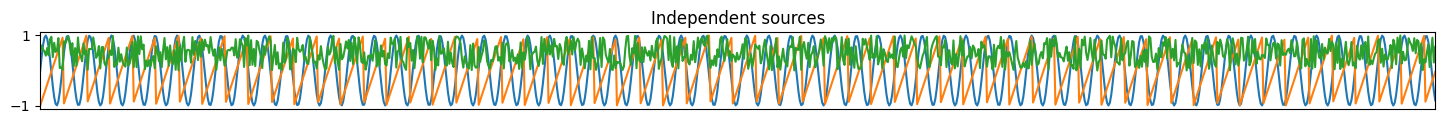

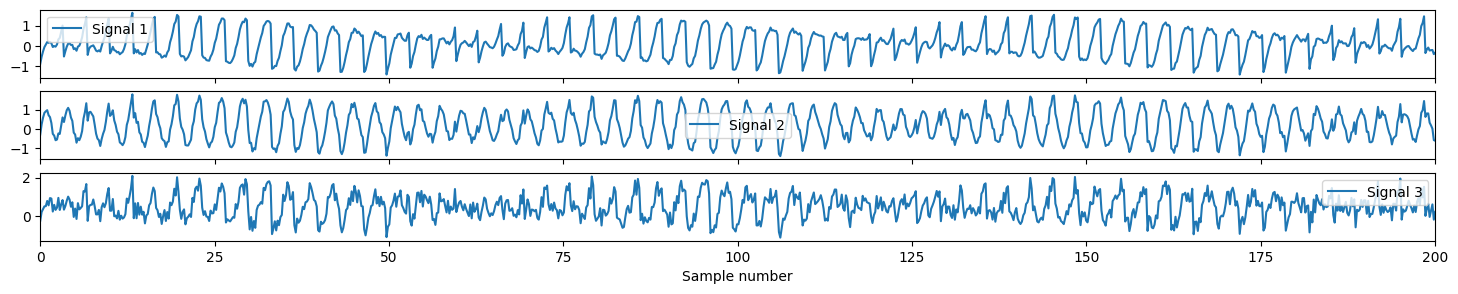

In [60]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 1])
ax.plot(t, S.T)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(t[0], t[-1])
ax.tick_params()
ax.set_title('Independent sources')

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3], sharex=True)
for signal_number, observed_signal in enumerate(X):
    ax[signal_number].plot(t, X[signal_number], label=f"Signal {signal_number + 1}")
    ax[signal_number].tick_params()
    ax[signal_number].legend()

ax[-1].set_xlabel('Sample number')
ax[-1].set_xlim(t[0], t[-1])
plt.show()

### A visual non-Gaussianity test

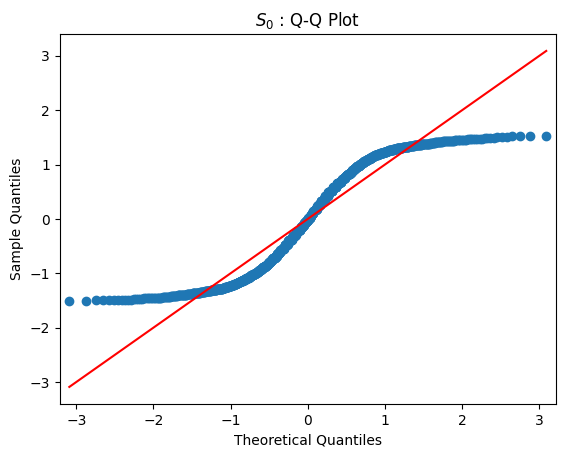

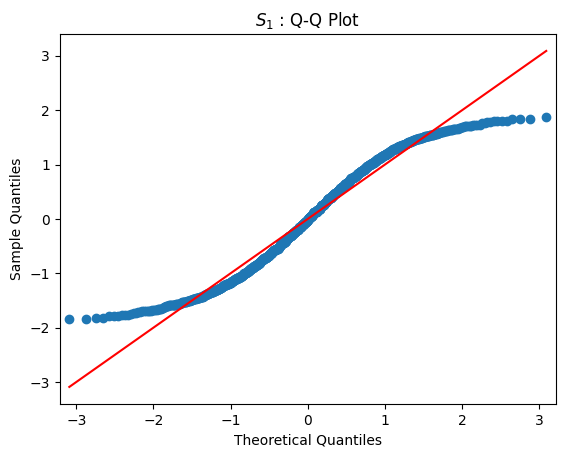

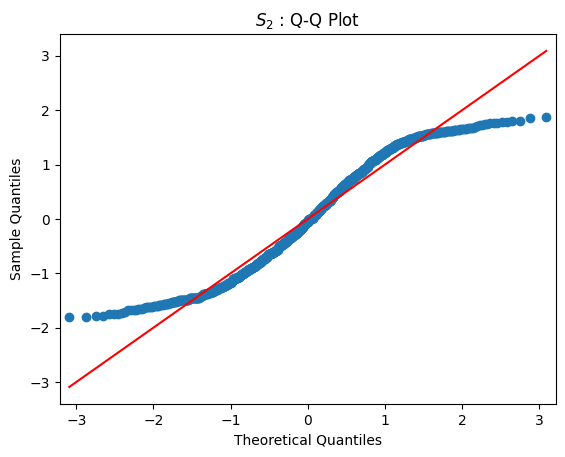

In [61]:
Sw, _, _ = centering_and_whitening(S)
import statsmodels.api as sm
# Create a Q-Q plot
for i in range(n_sources):
    sm.qqplot(Sw[i], line='s')
    plt.title(f'$S_{i}$ : Q-Q Plot')
    plt.show()


## ICA

In [62]:
# Center & whiten signals
X, meanX, whiteM = centering_and_whitening(X)
start_time=time.time()
W, mcc = fast_ica2(X, true_sources=S)
end_time=time.time()
print(f'Took {end_time-start_time} s to run')

unMixed = np.dot(W,X)

component 0
iteration : 0 : distance 0.007237732410430908
----- MCC = 0.4239647736152013
iteration : 1 : distance 6.556510925292969e-06
----- MCC = 0.423952912290891
iteration : 2 : distance 0.0
----- MCC = 0.42395253479480743
component 1
iteration : 0 : distance 0.8613985031843185
----- MCC = 0.6805411924918493
iteration : 1 : distance 0.06351613998413086
----- MCC = 0.699454183379809
iteration : 2 : distance 1.615285873413086e-05
----- MCC = 0.6994851976633072
iteration : 3 : distance 0.0
----- MCC = 0.6994832108418146
component 2
iteration : 0 : distance 0.8801925703883171
----- MCC = 0.9992112119992574
iteration : 1 : distance 0.0
----- MCC = 0.9992112119992574
Took 0.08813261985778809 s to run


In [63]:
import jax.numpy as jnp

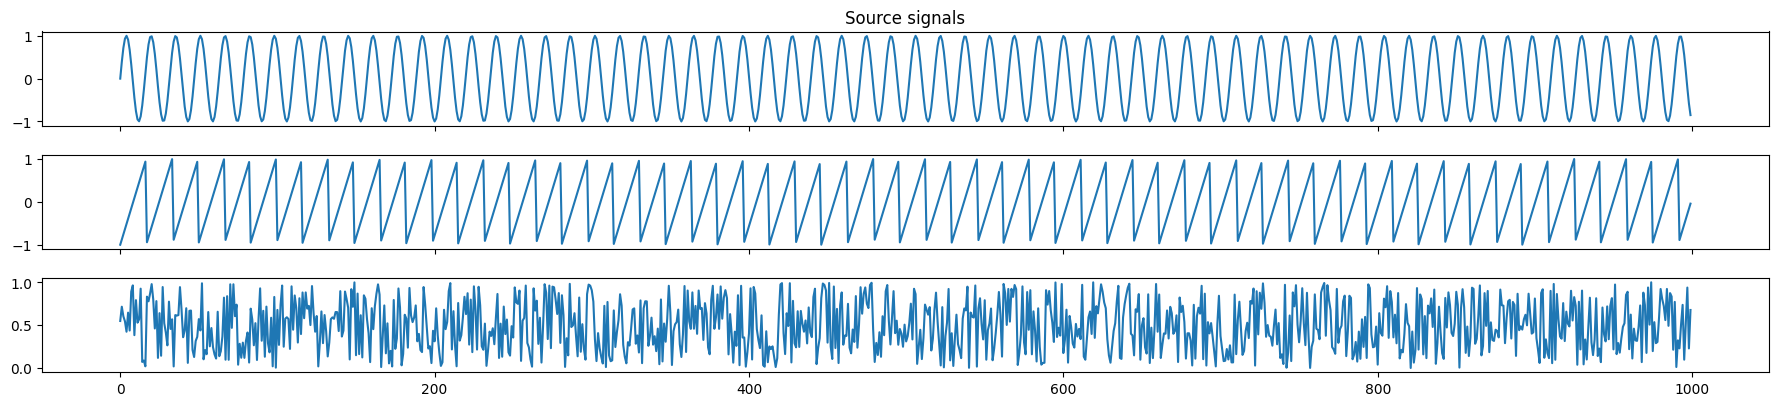

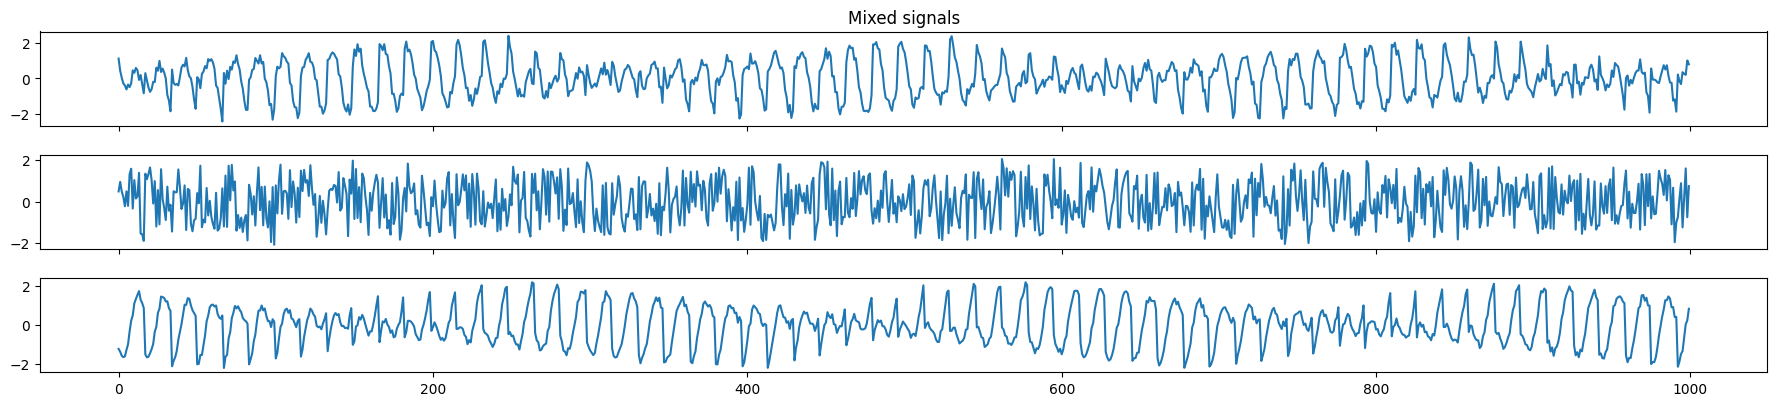

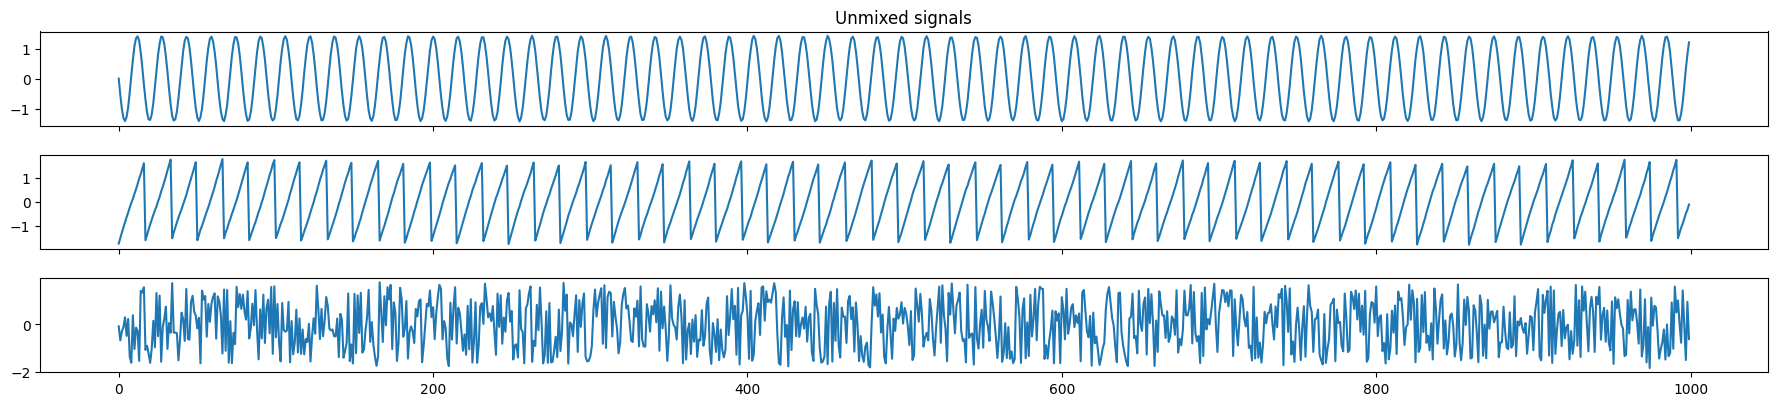

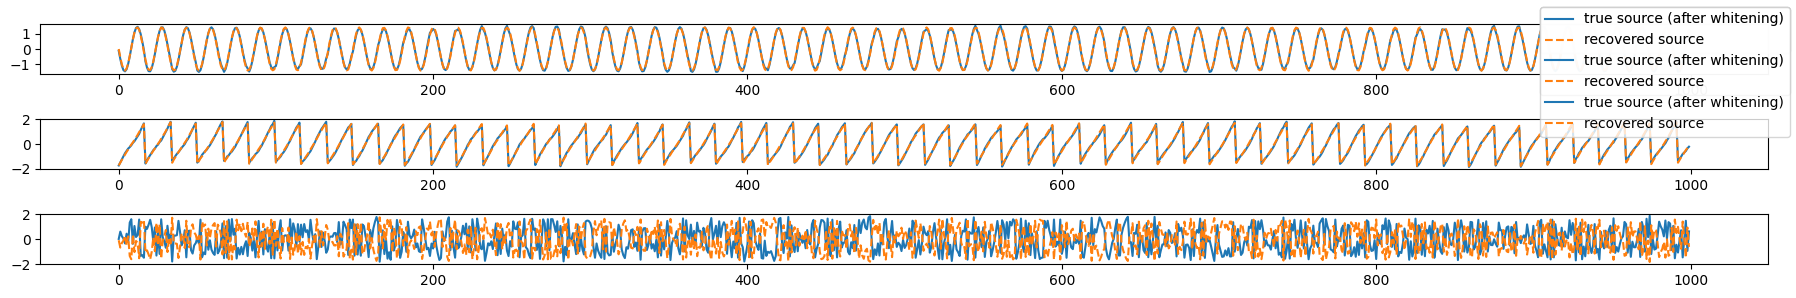

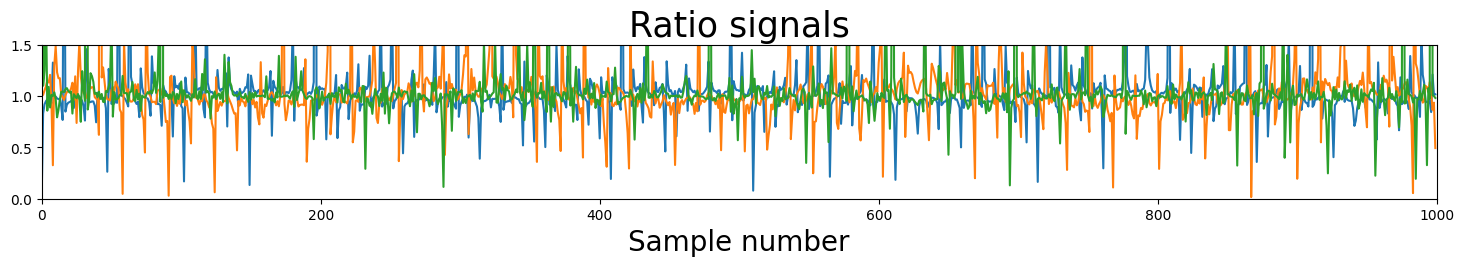

In [64]:
# Plot input signals (not mixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Source signals')
for i in range(n_signals):
    axes[i].plot(S[i])

# Plot mixed signals 
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Mixed signals')
for i in range(n_signals):
    axes[i].plot(X[i])


# Plot recovered signals (unmixed)
fig, axes = plt.subplots(nrows=n_signals, ncols=1, figsize=(18, 4),sharex=True)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
axes[0].set_title('Unmixed signals')
for i in range(n_signals):
    axes[i].plot(unMixed[i])

Sw, _, _ = centering_and_whitening(S)
perm = jnp.argmax(jnp.abs(unMixed @ S.T),
                    axis=0)

fig, ax = plt.subplots(n_signals, 1, figsize=[18, 3])
fig.tight_layout()
for i in range(n_signals):
    ax[i].plot(Sw[perm[i]].T, label='true source (after whitening)')
    ax[i].plot(unMixed[i].T,'--', label='recovered source')
    fig.legend()
    # ax.set_ylim(-1.5, 1.5)


fig, ax = plt.subplots(1, 1, figsize=[18, 2])
for i in range(n_sources):
    ax.plot(np.abs(unMixed[i].T / Sw[perm[i]].T), '-', label='Recovered signals')
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Ratio signals', fontsize=25)
ax.set_xlim(0, S.shape[1])
ax.set_ylim(0, 1.5)
plt.show()

Although estimated sources and true sources seem to match perfectly, we can see that the "ratio" signal is not completely flat. This is due to the zero values present in the signals.

# Figures in Latex

In [65]:
%pwd

'c:\\'

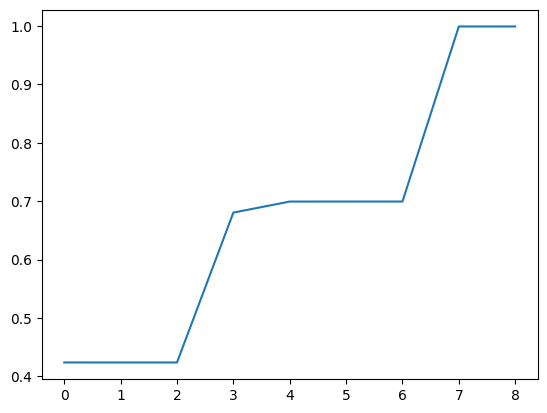

In [66]:
plt.plot(mcc)

In [67]:
# LaTeX code for the subplot
subplot_code_ = r'''
\nextgroupplot[
        title=Evolution of MCC during FastICA algorithm iterations on synthetic data,
        xlabel={iterations},
        ylabel={MCC Score},
        xmin=0, xmax=%d,
        ymin=%f, ymax=%f
        ]
\addplot[
    color=blue,
    mark=*,
    style={very thick},
] coordinates {
    %s
};
''' % (len(mcc)-1, min(mcc)-0.1, 1, ' '.join(f'({i},{score:.2f})' for i, score in enumerate(mcc)))

# Save the LaTeX code to a file
file_path = 'report/figures_latex/mcc_toy_sources_fastica.tex'  # Path to save the .tex file
with open(file_path, 'w') as file:
    file.write(subplot_code_.strip())


FileNotFoundError: [Errno 2] No such file or directory: 'report/figures_latex/mcc_toy_sources_fastica.tex'